In [48]:
import numpy as np
import math as math
import copy as copy
import matplotlib.pyplot as plt
import random

In [49]:
def sideLength(r):
    return int(math.sqrt(r.size))

def weight(rs):
    #elevation_arr = (elevation_arr1*.25 + elevation_arr2*.5 + elevation_arr3*.75 + elevation_arr4*3) /3
    r = np.full((sideLength(rs[0]),sideLength(rs[0])),0)
    for i in range(0, len(rs)):
        r = r + rs[i]*(i+1+i*i/(i+2)/(i+10))
    r = r/len(rs)
    return r

def MakeRandomMatrix(size):
    np.set_printoptions(threshold=np.nan)
    from scipy.ndimage.interpolation import zoom
    #elevation_arr1 = np.random.uniform(size=(100,100))
    #elevation_arr1 = zoom(elevation_arr1, 2)
    elevation_arr2 = np.random.uniform(size=(10,10))
    elevation_arr2 = zoom(elevation_arr2, size/10)
    elevation_arr3 = np.random.uniform(size=(4,4))
    elevation_arr3 = zoom(elevation_arr3, size/4)
    elevation_arr4 = np.random.uniform(size=(2,2))
    elevation_arr4 = zoom(elevation_arr4, size/2)
    elevation_arr5 = np.random.uniform(size=(1,1))
    elevation_arr5 = zoom(elevation_arr5, size)
    #print(math.sqrt(elevation_arr1.size))
    #print(math.sqrt(elevation_arr2.size))
    #print(math.sqrt(elevation_arr3.size))
    #print(math.sqrt(elevation_arr4.size))

    elevations = [elevation_arr2, elevation_arr3, elevation_arr4, elevation_arr5]
    
    raster = weight(elevations)
    
    return raster

def updateValue(arr, value, position):
    arr[position[0]][position[1]]=value
    return arr

In [50]:
def formLake(b_arr, e_arr, i, j):
    mtxSize = sideLength(e_arr)
    neighbours = np.array([[-1,0], [0,1], [1,0],[0,-1]])
    neighbourList = neighbours + tuple([i,j])
    #print("-------------------")
    pastElevation = -1000
    for a in range(0, random.randint(100,200)):
        #print(tuple([i,j]))
        newNeighbours = neighbours + tuple([i,j])
        neighbourList = np.concatenate((neighbourList, newNeighbours))
        #print(neighbourList)
        minElevation = 1000
        edge = False
        for a in range(0,len(neighbourList)):
            if(neighbourList[a][0]>=mtxSize or neighbourList[a][1]>=mtxSize or neighbourList[a][0]<0 or neighbourList[a][1]<0):
                edge = True
                break;
            wIndex = tuple(neighbourList[a])
            elevation = e_arr[wIndex]
            #print(wIndex, elevation, minElevation, pastElevation)
            if(elevation < minElevation and elevation > pastElevation):
                minElevation = elevation
                i = wIndex[0]
                j = wIndex[1]
        if(edge):
            break
        #print([i,j])
        b_arr = updateValue(b_arr, 20, tuple([i,j]))
        pastElevation = minElevation
        #print("--")
        
    return b_arr

In [51]:
def normalize(r, a, b, c, d):
    a = 0
    b = 10
    c = 8
    d = 15
    rmax = r.max()
    rmin = r.min()
    for i in range(0, sideLength(r)):
        for j in range(0, sideLength(r)):
            r[i][j]=(b-a)*(r[i][j]-rmin)/(rmax-rmin)+a
            if(r[i][j] > 8):
                r[i][j]=(d-c)*(r[i][j]-c)/(b-c)+c
    return r

0.0

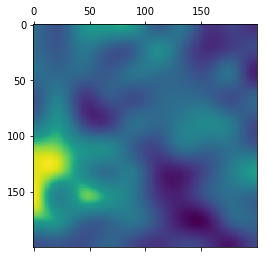

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
r = MakeRandomMatrix(200)
r = normalize(r, 0, 10, 8, 15)
waterElevation = 2
plt.matshow(r)
r.min()

In [53]:
def erode(e_arr):
    b_arr = MakeRandomMatrix(200)
    b_arr = normalize(b_arr, 0, 10, 8, 10)
    b_arr[e_arr < 2] = 20
    
    riverends = np.zeros((200,200))
    
    mtxSize = sideLength(e_arr)
    neighbours = np.array([[-1,0], [0,1], [1,0],[0,-1]])
    w_arr = np.full((mtxSize, mtxSize),.1)
    e_out = copy.copy(e_arr)
    eMaxIndex = tuple([0,5])
    wIndex = None
    while(e_arr.max() > -10000):
        eMaxIndex = np.unravel_index(np.argmax(e_arr, axis=None), e_arr.shape)
        newNeighbours = neighbours + eMaxIndex
        minElevation = e_arr.max()
        #if(wIndex is not None):
        #    print(w_arr[wIndex])
        wIndex = None
        edge = False
        for i in range(0,4):
            if(newNeighbours[i][0]>=mtxSize or newNeighbours[i][1]>=mtxSize or newNeighbours[i][0]<0 or newNeighbours[i][1]<0):
                edge = True
                break;
            elevation = e_arr[tuple(newNeighbours[i])]
            if(elevation < minElevation and elevation != -10000):
                wIndex = tuple(newNeighbours[i])
                minElevation = elevation
        if(wIndex is not None):
            waterVolume = w_arr[eMaxIndex]+w_arr[wIndex]
            if(waterVolume > 10):
                waterVolume = 10
                b_arr = updateValue(b_arr, 20, wIndex)
            w_arr = updateValue(w_arr, waterVolume, wIndex)
            e_out = updateValue(e_out, e_out[eMaxIndex] + waterVolume*.2, eMaxIndex)
            e_out = updateValue(e_out, e_out[wIndex] - waterVolume*.22, wIndex)
        elif(not edge):
            e_out = updateValue(e_out, e_out[eMaxIndex] + w_arr[eMaxIndex]*.2, eMaxIndex)
            riverends = updateValue(riverends, 1, eMaxIndex)
            pass
        e_arr = updateValue(e_arr, -10000, eMaxIndex)
    
    lakes = np.zeros(mtxSize)
    for i in range(0, mtxSize):
        for j in range(0, mtxSize):
            if(riverends[i][j] != 0):
                b_arr = formLake(b_arr, e_out, i,j)

    
    return e_out, w_arr, b_arr

In [54]:
print(r.min())
r, water_arr, b_arr = erode(r)

0.0


       (b-a)(x - min)
f(x) = --------------  + a
          max - min

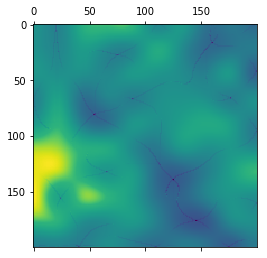

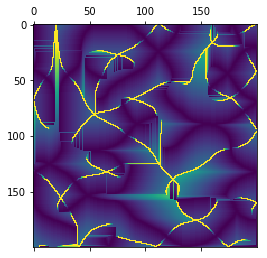

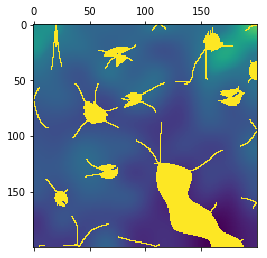

In [55]:
%matplotlib inline

plt.matshow(r) 
plt.matshow(water_arr)
plt.matshow(b_arr)
np.savetxt("text2.csv", water_arr, fmt='%f,')

(198, 131)
<type 'tuple'>
23.4466849668
23.4466849668


In [377]:
np.savetxt("text.csv", new_elevation_arr, fmt='%f,')

In [378]:
np.savetxt("text2.csv", biomeArr, fmt='%f,')